In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 6.0MB/s 


In [3]:
!rm /content/functions_term.py
!cp /content/drive/MyDrive/TrainModels/functions_term.py /content/functions_term2.py

rm: cannot remove '/content/functions_term.py': No such file or directory


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import scipy.io as sio
import pandas as pd
import glob

In [37]:
path='/content/drive/MyDrive/TrainModels/'
path_w=path+'weights/'
figures=path+'Figures/'

In [192]:
df = pd.DataFrame(columns=('run_n', 'network', 'optimizer', 'loss', 'epochs', 'total_parameters', 'time','augm','acc','sensitivity','specificity','FPR','result_mat'))
csvs=glob.glob(path+'*a.csv')
print(np.shape(csvs))
for name_c in csvs:
  csv=pd.read_csv(name_c)
  csv=csv.drop(csv.columns[:np.where(csv.columns=='run_n')[0][0]], axis=1)  
  df=df.append(csv, ignore_index=True)

(9,)


### Summary

In [193]:
dfx=df.copy()
df[["network", "acc", "sensitivity", "specificity", 'FPR']].groupby("network").describe().sort_values(by=[('acc',   'max')], ascending=False)

acc                      ...       FPR                    
              count      mean       std  ...       50%       75%       max
network                                  ...                              
resnet50v2     32.0  0.805147  0.100715  ...  0.191176  0.294118  0.382353
DFTNet         31.0  0.821632  0.189994  ...  0.117647  0.176471  0.823529
Transformer_x  32.0  0.775735  0.068367  ...  0.117647  0.161765  0.323529

[3 rows x 32 columns]

In [195]:
#df.loc[df['network']=='DFTNet'].sort_values(by='acc', ascending=False)[['acc', 'sensitivity', 'specificity', 'FPR']]

In [196]:
camb={'resnet50v2': 'ResNet50v2','DFTNet':'DFTNet','Transformer_x':'Transformer'}

In [197]:
for n,i in enumerate(df.iloc[:,1]):
  df.iloc[n,1]=camb[df.iloc[n,1]]

### Graphics

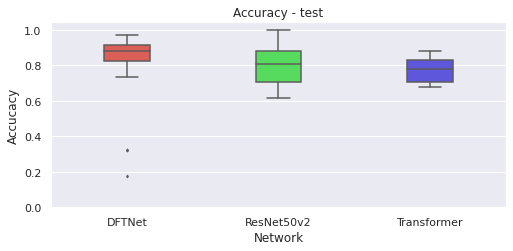

In [198]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8.15, 3.4)})
sns.boxplot(x='network', y='acc', data=df, palette='hls', width=0.3, saturation=1, fliersize=2)
#plt.xticks(np.arange(3), ['DFTNet','ResNet50v2','Transformer'])
plt.title('Accuracy - test')
plt.ylabel('Accucacy')
plt.xlabel('Network')
plt.ylim((0))
print('')
plt.savefig('general.svg')

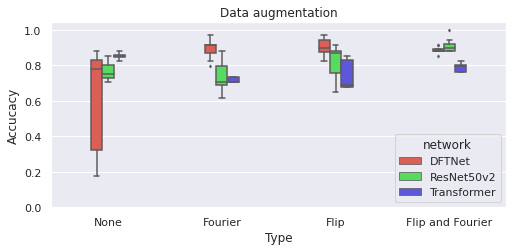

In [200]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8.16, 3.4)})
sns.boxplot(x='augm', y='acc', data=df, hue='network', palette='hls', width=0.3, saturation=1, fliersize=2)
plt.xticks(np.arange(4), ['None','Fourier','Flip','Flip and Fourier'])
plt.title('Data augmentation')
plt.ylabel('Accucacy')
plt.xlabel('Type')
plt.ylim((0))
print('')
plt.savefig('dataaumentation.svg')

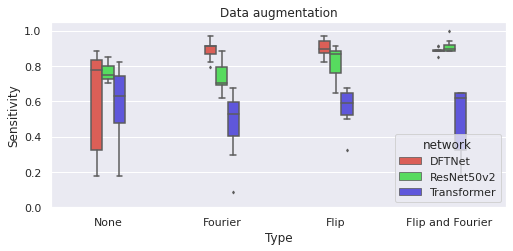

In [201]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8.16, 3.4)})
sns.boxplot(x='augm', y='sensitivity', data=df, hue='network', palette='hls', width=0.3, saturation=1, fliersize=2)
plt.xticks(np.arange(4), ['None','Fourier','Flip','Flip and Fourier'])
plt.title('Data augmentation')
plt.ylabel('Sensitivity')
plt.xlabel('Type')
plt.ylim((0))
print('')
plt.savefig('sensibilidad.svg')

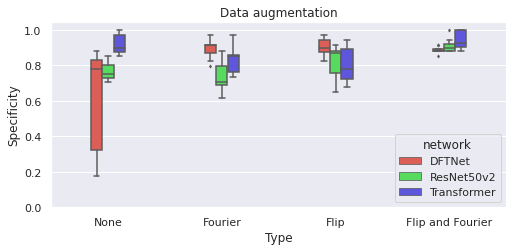

In [202]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8.16, 3.4)})
sns.boxplot(x='augm', y='specificity', data=df, hue='network', palette='hls', width=0.3, saturation=1, fliersize=2)
plt.xticks(np.arange(4), ['None','Fourier','Flip','Flip and Fourier'])
plt.title('Data augmentation')
plt.ylabel('Specificity')
plt.xlabel('Type')
plt.ylim((0))
print('')
plt.savefig('specificidad.svg')

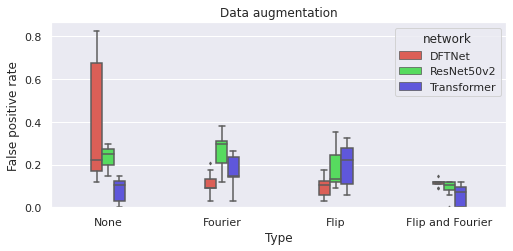

In [203]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8.16, 3.4)})
sns.boxplot(x='augm', y='FPR', data=df, hue='network', palette='hls', width=0.3, saturation=1, fliersize=2)
plt.xticks(np.arange(4), ['None','Fourier','Flip','Flip and Fourier'])
plt.title('Data augmentation')
plt.ylabel('False positive rate')
plt.xlabel('Type')
plt.ylim((0))
print('')
plt.savefig('falsospositivos.svg')

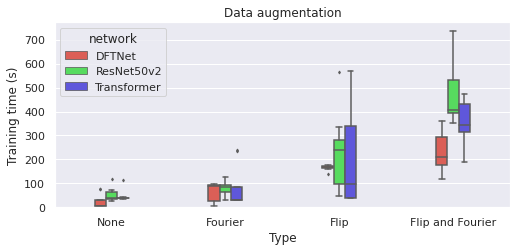

In [204]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8.16, 3.4)})
sns.boxplot(x='augm', y='time', data=df, hue='network', palette='hls', width=0.3, saturation=1, fliersize=2)
plt.xticks(np.arange(4), ['None','Fourier','Flip','Flip and Fourier'])
plt.title('Data augmentation')
plt.ylabel('Training time (s)')
plt.xlabel('Type')
plt.ylim((0))
print('')
plt.savefig('tiempo de entrenamiento.svg')

### Model

In [43]:
import functions_term2 as ter
import time
import tensorflow as tf
import os
network=['resnet50v2', 'Transformer', 'DFTNet']

In [44]:
def test_model(df4, xtest, net='resnet50v2', metric='acc'):
  try:
    del model
  except:
    print('done')

  dafra=df4.loc[df4['network']==net]
  ind=np.where(dafra[metric]==np.max(dafra[metric]))[0][0]
  print(dafra.iloc[ind])
  model=ter.get_model(net,'Adadelta', 'categorical_crossentropy')
  model.load_weights(dafra.iloc[ind]['result_mat'][:-4]+'w.h5')
  tic=time.time()
  yhat=model.predict(xtest)
  toc=time.time()
  #save_csv(net, np.shape(xtest), toc-tic)
  return yhat

In [45]:
root_path = "/content/drive/MyDrive/TrainModels/Diabetes"
database_path = os.path.join(os.path.join(root_path,'ThermoDataBase'),"Plantar Thermogram Database.xlsx")
roi=['L', 'L_LCA',	'L_LPA',	'L_MCA',	'L_MPA', 'R', 'R_LCA',	'R_LPA',	'R_MCA',	'R_MPA']
data=sio.loadmat(root_path+'/data.mat')
imargb=data['RGB']
imagra=data['Gray']
index =data['index']
type_p=data['type'][0]
gender=data['gender'][0]
siz=np.shape(imargb)

In [46]:
x_images=np.concatenate((imagra[:,0,:,:],imagra[:,5,:,:])).astype('float32')
x_images=x_images/np.max(x_images)
x_images=x_images.reshape((np.shape(x_images)[0], np.shape(x_images)[1], np.shape(x_images)[2], 1))
x_images=np.array(tf.image.grayscale_to_rgb(tf.constant(x_images)))
y_labels=np.concatenate((type_p, type_p))
name=np.concatenate((index, index))

In [47]:
sub=[]
for n,i in enumerate(name):
  if y_labels[n]==1:
    gp='DM'
  else:
    gp='CG'
  if n>=167:
    lat='_R'
    #cont=cont+1
  else:
    lat='_L'
  sub.append(gp+i+lat)

In [49]:
y_hat=test_model(dfx, x_images)

done
run_n                                                               3
network                                                    resnet50v2
optimizer                                                    Adadelta
loss                                         categorical_crossentropy
epochs                                                            200
total_parameters                                             23568898
time                                                          735.294
augm                                            rot_True_fourier_True
acc                                                                 1
sensitivity                                                         1
specificity                                                         1
FPR                                                       2.94118e-09
result_mat          /content/drive/MyDrive/TrainModels/weights/5Th...
Name: 58, dtype: object
done
94674944/94668760 [==============================] - 1s 

(80.0, 105.0)

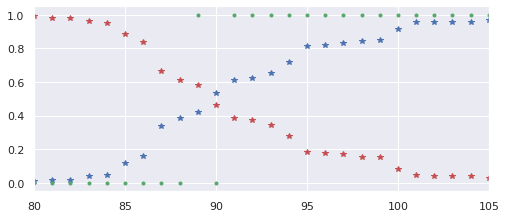

In [50]:
order=np.argsort(y_hat[:,1])
plt.plot(y_hat[:,0][order], '*r')
plt.plot(y_hat[:,1][order], '*b')
plt.plot(y_labels[order], '.g')
plt.xlim((80, 105))

In [51]:
df_CG = pd.read_excel(database_path, header=[0, 1], index_col=[0], sheet_name='Control Group')
df_DM = pd.read_excel(database_path, header=[0, 1], index_col=[0], sheet_name='DM Group')
group_frame=df_CG.iloc[:,[10,16]].append(df_DM.iloc[:,[10,16]]) 

In [52]:
TCI=[]
TCIm=[]
for si in np.array(sub)[order]:
  val=group_frame.loc[si[:-2]].values
  if len(np.shape(val))==2:
    val=np.mean(group_frame.loc[si[:-2]].values, axis=0)
  if si[-1:]=='R':
    pos=0
  else:
    pos=1
  TCI.append(val[pos])
  TCIm.append(np.abs(val[0]-val[1]))

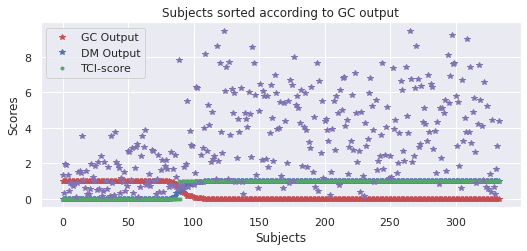

In [53]:
sns.set(rc={'figure.figsize':(8.6, 3.4)})
order=np.argsort(y_hat[:,1])
plt.plot(y_hat[:,0][order], '*r')
plt.plot(y_hat[:,1][order], '*b')
plt.plot(y_labels[order], '.g')
plt.plot(np.array(TCI), '*m')
plt.legend(['GC Output', 'DM Output', 'TCI-score'])
plt.title('Subjects sorted according to GC output')
plt.xlabel('Subjects')
plt.ylabel('Scores')
plt.savefig('conTCI.svg')
#plt.xlim((80, 105))
#Multiplicar por 0.4797089917
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||##

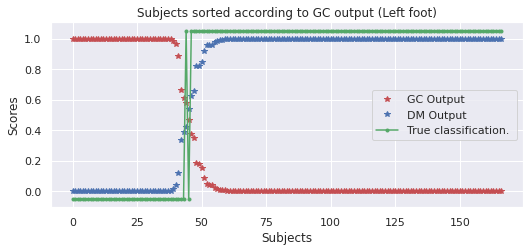

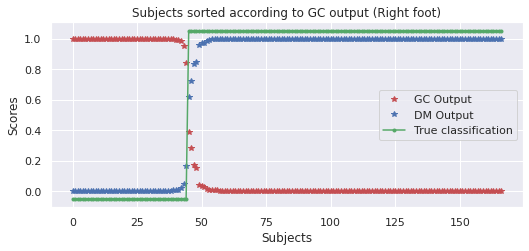

In [54]:
#dos pies
sns.set(rc={'figure.figsize':(8.45, 3.4)})
orderx=np.argsort(y_hat[:167][:,1])
plt.plot(y_hat[:167][:,0][orderx], '*r')
plt.plot(y_hat[:167][:,1][orderx], '*b')
plt.plot((y_labels[:167][orderx])*1.1-0.05, '.-g')
plt.legend(['GC Output', 'DM Output', 'True classification. '])
plt.title('Subjects sorted according to GC output (Left foot)')
plt.xlabel('Subjects')
plt.ylabel('Scores')
plt.savefig('pieIzquierdo.svg')


plt.figure()
sns.set(rc={'figure.figsize':(8.6, 3.4)})
order2=np.argsort(y_hat[167:][:,1])
plt.plot(y_hat[167:][:,0][order2], '*r')
plt.plot(y_hat[167:][:,1][order2], '*b')
plt.plot((y_labels[167:][order2])*1.1-0.05, '.-g')
plt.legend(['GC Output', 'DM Output', 'True classification'])
plt.title('Subjects sorted according to GC output (Right foot)')
plt.xlabel('Subjects')
plt.ylabel('Scores')
plt.savefig('piederecho.svg')
#plt.xlim((30, 55))
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||##

In [55]:
promed=(y_hat[:167]+y_hat[167:])/2

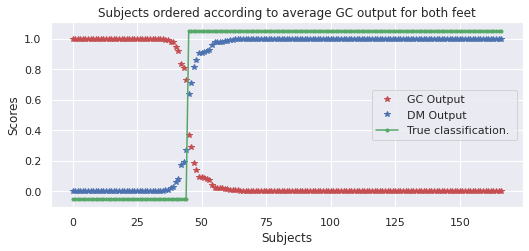

In [56]:
#dos pies
sns.set(rc={'figure.figsize':(8.45, 3.4)})
order3=np.argsort(promed[:,1])
plt.plot(promed[:,0][order3], '*r')
plt.plot(promed[:,1][order3], '*b')
plt.plot((y_labels[:167][order3])*1.1-0.05, '.-g')
plt.legend(['GC Output', 'DM Output', 'True classification. '])
plt.title('Subjects ordered according to average GC output for both feet')
plt.xlabel('Subjects')
plt.ylabel('Scores')
plt.savefig('ambospies.svg')

In [57]:
ajus=((x_images-np.min(x_images[x_images!=0]))/(np.max(x_images[x_images!=0])-np.min(x_images[x_images!=0])))
ajus[ajus<0]=0

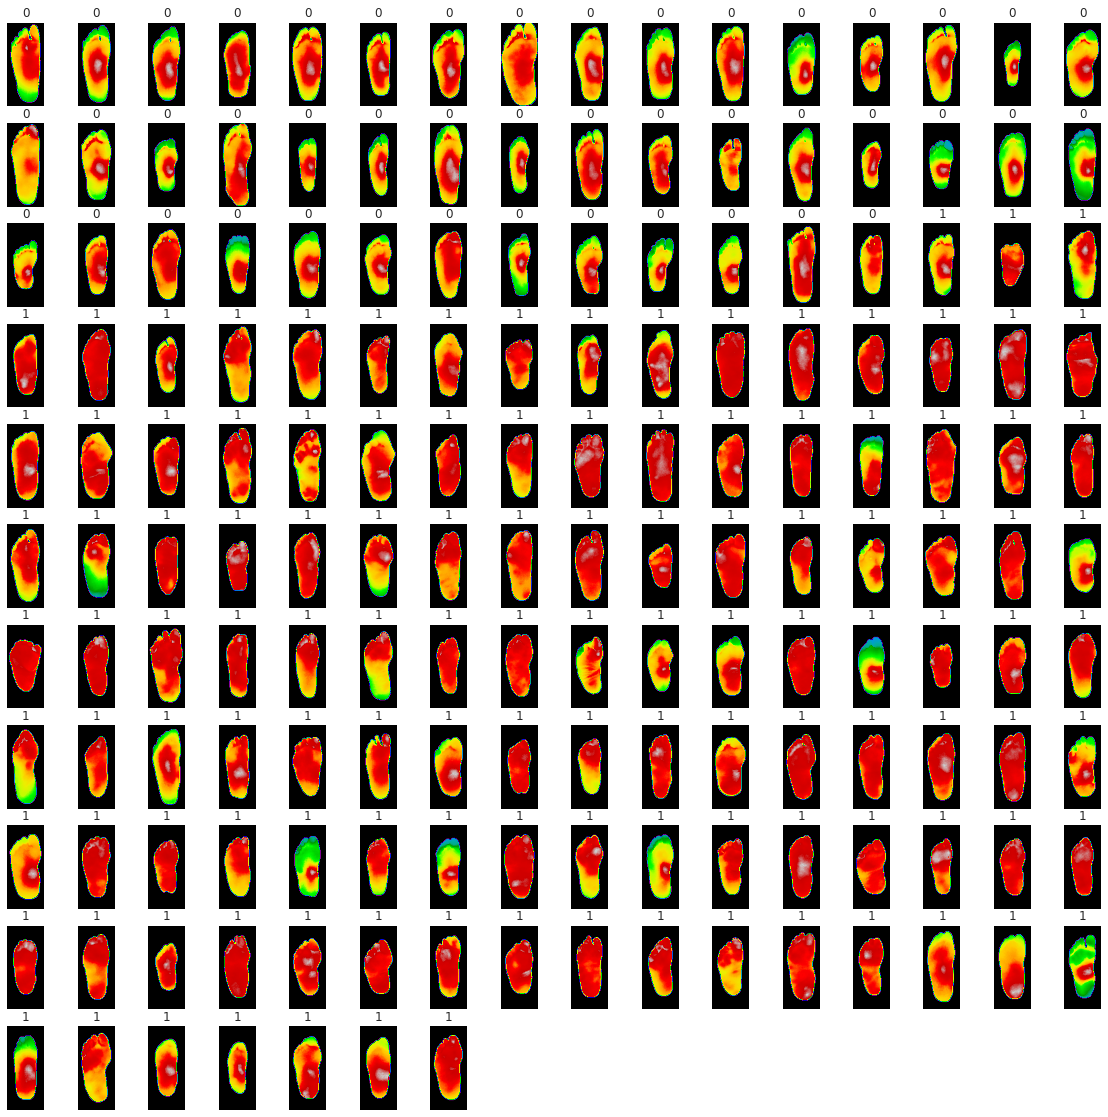

In [58]:
plt.figure(figsize=(20,20))
for n,i in enumerate(order2):
  plt.subplot(11,16,n+1)
  plt.imshow(ajus[167+i,:,:,0], cmap='nipy_spectral')
  plt.title(y_labels[i])
  plt.axis('off')

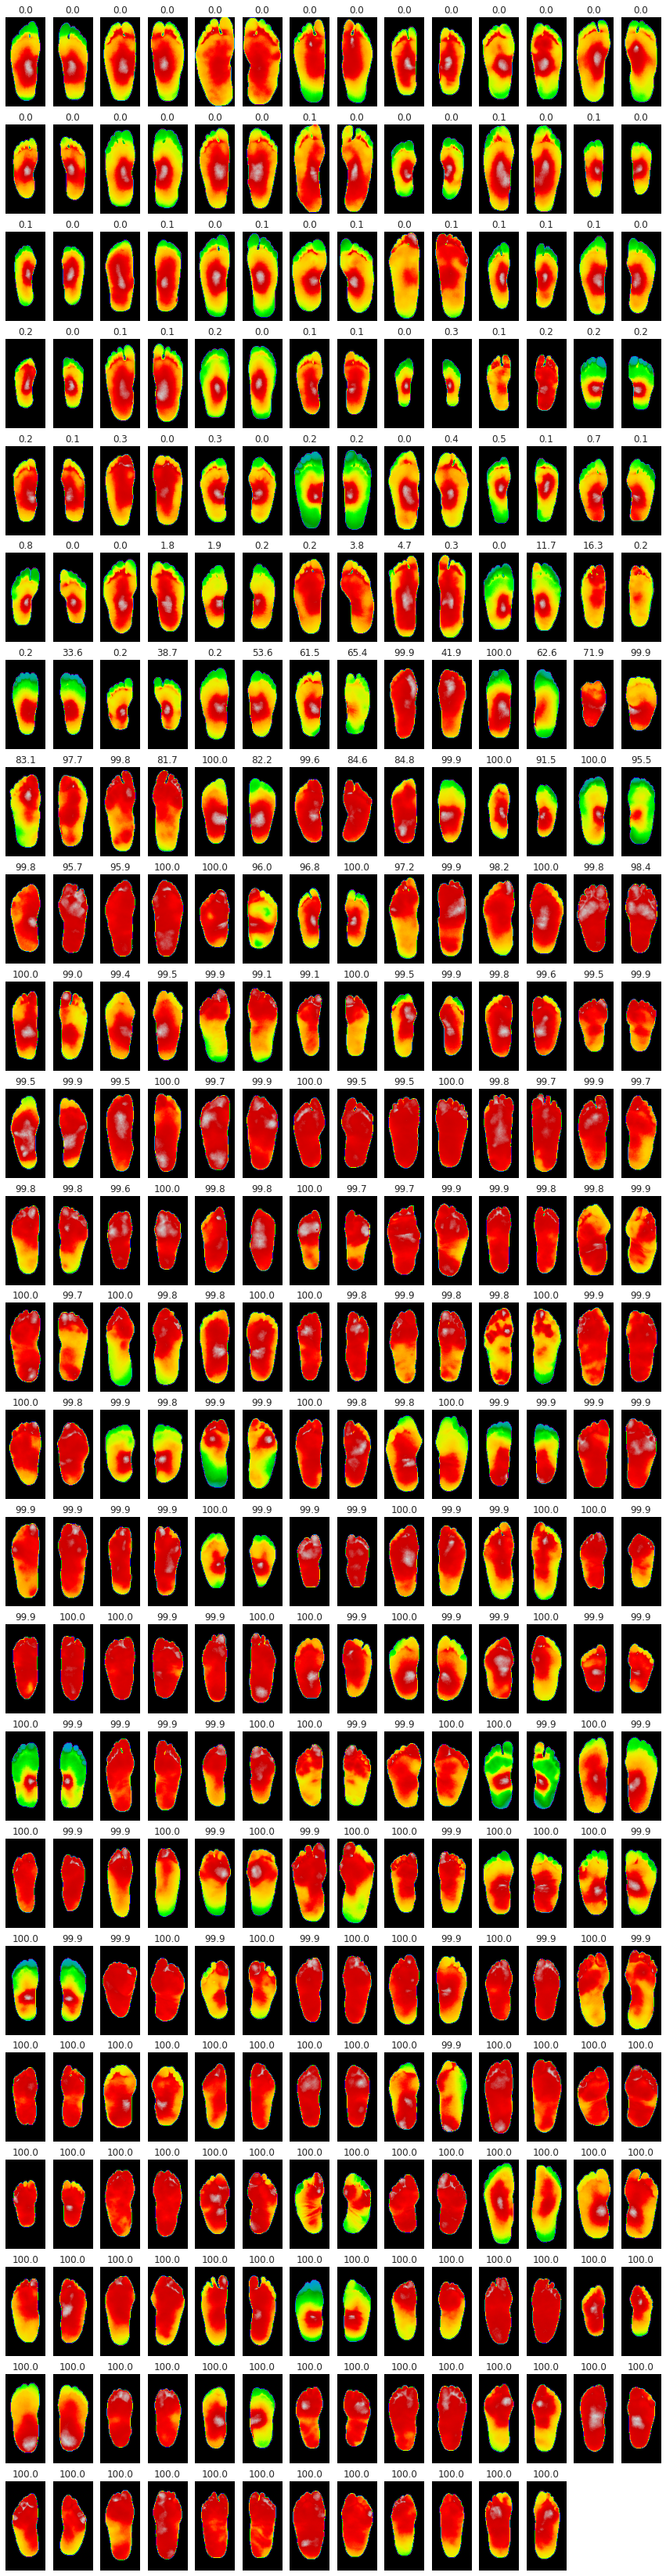

In [59]:
plt.figure(figsize=(15,60))
for n,i in enumerate(order3):
  plt.subplot(24,14,2*n+1)
  plt.imshow(ajus[167+i,:,:,0], cmap='nipy_spectral')
  plt.title(np.round(y_hat[167+i][1]*100,1))
  plt.axis('off')
  plt.subplot(24,14,2*n+2)
  plt.imshow(ajus[i,:,:,0], cmap='nipy_spectral')
  plt.title(np.round(y_hat[i][1]*100,1))
  plt.axis('off')
plt.savefig('todoslospies.svg')

In [60]:
np.where((np.argmax(y_hat, axis=1)==y_labels)==False)

(array([ 91, 133]),)

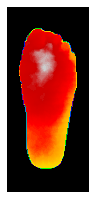

In [61]:
plt.imshow(ajus[91,:,:,0], cmap='nipy_spectral')
plt.axis('off') #clasificado erroneamente como no diabético
plt.savefig('FalsoNegativo.svg')

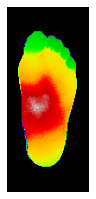

In [62]:
plt.imshow(ajus[133,:,:,0], cmap='nipy_spectral')
plt.axis('off') ##clasificado erroneamente como diabético
plt.savefig('FalsoPositivo.svg')

In [63]:
x_train=np.concatenate((x_images, np.flip(x_images, axis=1), np.flip(x_images, axis=2), np.flip(np.flip(x_images, axis=1), axis=2)))
y_train=np.concatenate((type_p, type_p, type_p, type_p))

In [64]:
y_prueba=test_model(dfx, x_train)

done
run_n                                                               3
network                                                    resnet50v2
optimizer                                                    Adadelta
loss                                         categorical_crossentropy
epochs                                                            200
total_parameters                                             23568898
time                                                          735.294
augm                                            rot_True_fourier_True
acc                                                                 1
sensitivity                                                         1
specificity                                                         1
FPR                                                       2.94118e-09
result_mat          /content/drive/MyDrive/TrainModels/weights/5Th...
Name: 58, dtype: object
done


In [205]:
cam_aug={'rot_False_fourier_False':'None',
         'rot_False_fourier_True':'Fourier',
         'rot_True_fourier_False':'Flip',
         'rot_True_fourier_True':'Flip & Fourier'}

In [206]:
def plot_training(frax, net='resnet50v2', metric='acc', title='Training', vmin=0, vmax=1.1):
  frax=frax.loc[frax['network']==net]
  xt=[]
  yt=[]
  augt=[]
  for i in range(len(frax)):
    nam=frax.iloc[i,:]['result_mat']
    aug=frax.iloc[i,:]['augm']
    matx=sio.loadmat(nam)[metric][0]
    x=np.linspace(1,np.shape(matx)[0],np.shape(matx)[0])
    augt=np.append(augt, [cam_aug[aug] for d in range(np.shape(matx)[0])])
    xt=np.append(xt,x)
    yt=np.append(yt,matx)
  dg=pd.DataFrame({'x':xt,'y':yt, 'Augmentation':augt})
  sns.lineplot(x="x", y="y", hue='Augmentation', data=dg)
  plt.ylabel(metric)
  plt.xlabel('Epoch')
  plt.title(title)
  #plt.ylim(vmin, vmax)

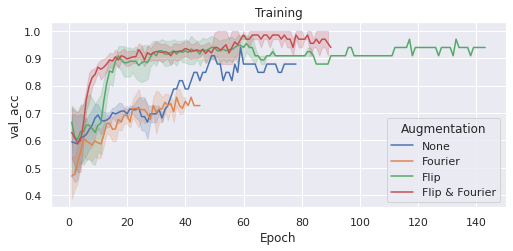

In [207]:
sns.set(rc={'figure.figsize':(8.15, 3.4)})
plot_training(dfx, metric='val_acc')
plt.savefig('acc_val.svg')

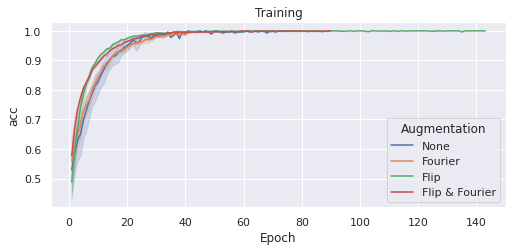

In [208]:
plot_training(dfx, metric='acc')
plt.savefig('acc.svg')

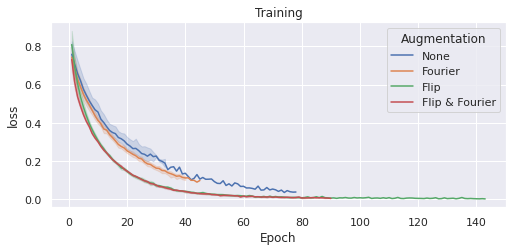

In [209]:
plot_training(dfx, metric='loss')
plt.savefig('a_loss.svg')

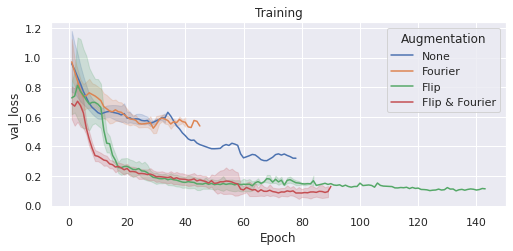

In [210]:
plot_training(dfx, metric='val_loss')
plt.savefig('a_loss_val.svg')